<a href="https://colab.research.google.com/github/Karanegi21/Fintech_project_1/blob/main/Copy_of_Karan_negi_task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Strategy implementation

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

In [ ]:
def ema(data, window):
    return data['Close'].ewm(span=window, adjust=False).mean()

In [ ]:
def rsi(data, window):
    price_diff = data['Close'].diff(1)
    gain = price_diff.where(price_diff > 0, 0)
    loss = -price_diff.where(price_diff < 0, 0)

    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

In [ ]:
def generate_signals(data, ema_window, rsi_window, rsi_overbought, rsi_oversold):
    signals = pd.DataFrame(index=data.index)
    signals['EMA'] = ema(data, ema_window)
    signals['RSI'] = rsi(data, rsi_window)

    # Generate trading signals
    signals['Signal'] = 0
    signals['Signal'][signals['EMA'] > data['Close']] = 1  # Long signal
    signals['Signal'][signals['EMA'] < data['Close']] = -1  # Short signal
    signals['Signal'][(signals['RSI'] > rsi_overbought) & (signals['Signal'] == 1)] = 0  # Exit long
    signals['Signal'][(signals['RSI'] < rsi_oversold) & (signals['Signal'] == -1)] = 0  # Exit short

    return signals


In [ ]:
def portfolio_clc(data, signals, initial_capital=10000, compound=True):
    positions = pd.DataFrame(index=data.index)
    positions['Position'] = signals['Signal']
    positions['Stock'] = 50 * positions['Position']  # Assume 50 shares per trade

    # Daily portfolio value
    portfolio = positions.multiply(data['Close'], axis=0)
    pos_diff = positions.diff()

    # Add cash holdings to the portfolio
    portfolio['Cash'] = initial_capital - (pos_diff['Stock'] * data['Close']).cumsum()

    # Total portfolio value
    portfolio['Total'] = portfolio['Stock'] + portfolio['Cash']

    # Daily returns
    portfolio['Returns'] = portfolio['Total'].pct_change()

    if compound:
        portfolio['Returns'] = (1 + portfolio['Returns']).cumprod() - 1

    return portfolio

In [ ]:
ticker = 'ITC.NS'
start_date = '2016-05-07'
end_date = '2022-12-31'

data = yf.download(ticker, start=start_date, end=end_date)
ema_window = 20
rsi_window = 14
rsi_overbought = 70
rsi_oversold = 30

signals = generate_signals(data, ema_window, rsi_window, rsi_overbought, rsi_oversold)
portfolio = portfolio_clc(data, signals)


[*********************100%%**********************]  1 of 1 completed
<ipython-input-6-0cdcc7557ace>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals['Signal'][signals['EMA'] > data['Close']] = 1  # Long signal
<ipython-input-6-0cdcc7557ace>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals['Signal'][signals['EMA'] < data['Close']] = -1  # Short signal
<ipython-input-6-0cdcc7557ace>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

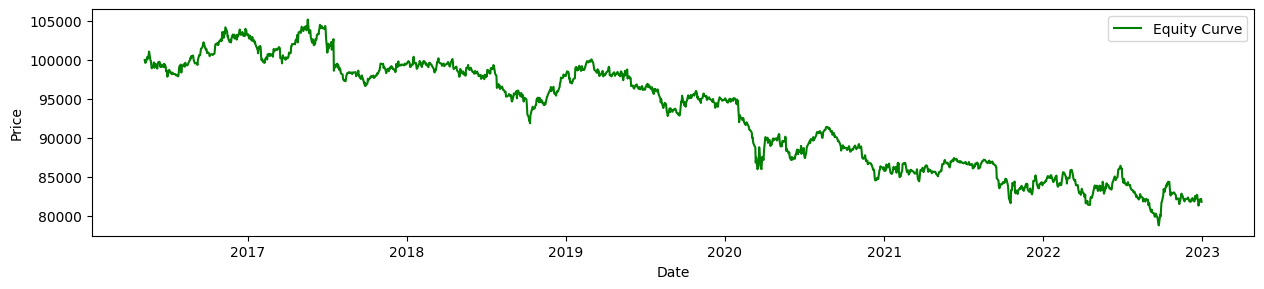

In [ ]:
#equity curve
plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 1)
plt.plot(portfolio['Total'], label='Equity Curve',color='green')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()



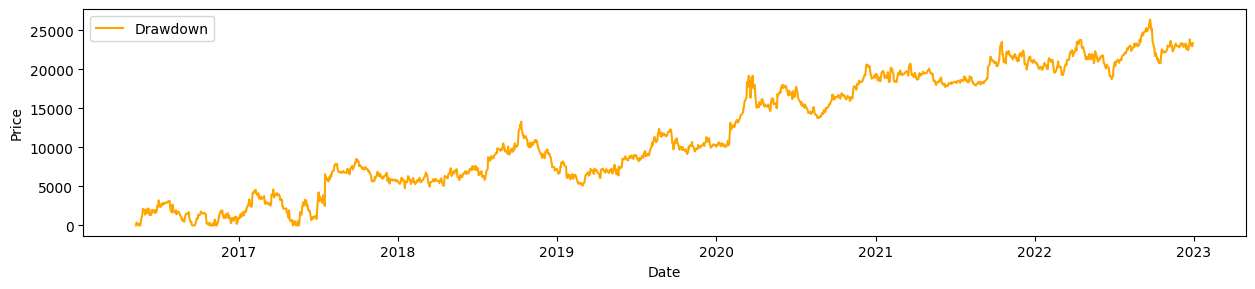

In [ ]:
#drawdown chart
plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 2)
plt.plot(portfolio['Total'].cummax() - portfolio['Total'], label='Drawdown',color='orange')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()


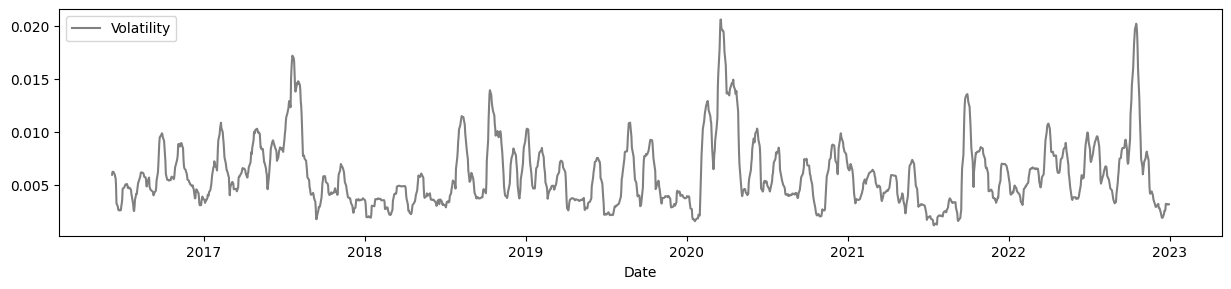

In [ ]:
# volatility chart
plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 3)
plt.plot(portfolio['Returns'].rolling(window=20).std(), label='Volatility',color='grey')
plt.xlabel('Date')
plt.ylabel('')
plt.legend()
